<a href="https://colab.research.google.com/github/yxs4yt/lab_scraping/blob/main/L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.
4. Document all your work as code and markdown blocks in this notebook.

In [1]:
# L1: Morgan Simmons, Rachel Kang, and Mark Haller

# 1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.

# Instead of cars, our group picked auto parts to scrap. When looking at the source code we want to look at the title, price, and location. We would want to look at the trends in our data through graphs. This could come in the form of the price distribution or where common locations of sellers are. This will also help with visualizing and summarizing the data we found.

In [2]:
# 2.Get your search results of interest using requests and extract data from them using beautifulSoup, using code similar to what's above.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/pta?purveyor=owner#search=2~gallery~0'
raw = requests.get(url, headers=header)

from bs4 import BeautifulSoup

soup = BeautifulSoup(raw.content, 'html.parser') #Parse the HTML
listings = soup.find_all(class_='cl-static-search-result')

In [3]:
# 3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

import re # Regular expressions

parts = [
    'lens','tripod','flash','filter','adapter','mount','battery','charger','case',
    'bag','remote','light','lighting','stand','gimbal','slider','monitor','microphone',
    'cable','cord','memory','sd','cf','shutter','body','grip'
]

data = [] # We'll save our listings in this object

for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']

    hood_el = listings[k].select_one('.result-hood')
    location = hood_el.get_text().strip(" ()") if hood_el else 'unknown'

    # Detect part keyword in title
    words = title.split()
    hits  = [w for w in words if w in parts]
    part  = hits[0] if hits else 'other'


    data.append({'title':title,'price':price,'link':link,'parts':parts})

    df = pd.DataFrame.from_dict(data)

# price → numeric
df['price'] = (
    df['price'].astype(str)
               .str.replace('$','', regex=False)
               .str.replace(',','', regex=False)
               .replace({'': np.nan, 'None': np.nan})
)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [4]:
import os

os.makedirs('./src', exist_ok=True)  # creates folder if it doesn't exist
df.to_csv('./src/craigslist_cville_autoparts.csv', index=False)

## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('./src/craigslist_cville_autoparts.csv') # Save data in case of a disaster
df.head()

missing_parts = (
    df['parts'].isna() |
    (df['parts'].str.strip() == "") |
    (df['parts'].str.lower() == "missing")
).sum()

print("Number of missing parts entries:", missing_parts)

(174, 4)
Number of missing parts entries: 0


count      174.000000
mean       562.321839
std       1826.854117
min          0.000000
25%         36.250000
50%        100.000000
75%        300.000000
max      18500.000000
Name: price, dtype: float64


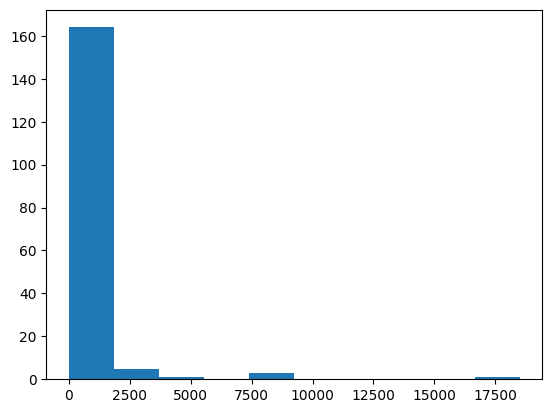

In [5]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()

In [6]:
# Price by parts:
parts_keywords = df['parts'].iloc[0] if len(df) else []

def detect_part(title, keywords):
    tokens = re.findall(r"[a-z0-9\-']+", str(title).lower())
    for w in tokens:
        if w in keywords:
            return w
    return 'other'

df['part_single'] = df['title'].apply(lambda t: detect_part(t, parts_keywords))

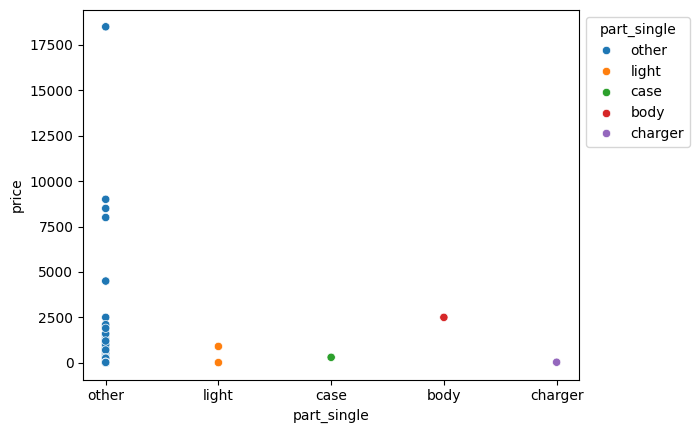

In [7]:
# Price by parts:
#df.groupby('parts')['price'].describe()
# or, same selection style you used:
#df.loc[:, ['price', 'parts']].groupby('parts').describe()

ax = sns.scatterplot(data=df, x='part_single', y='price', hue='part_single')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

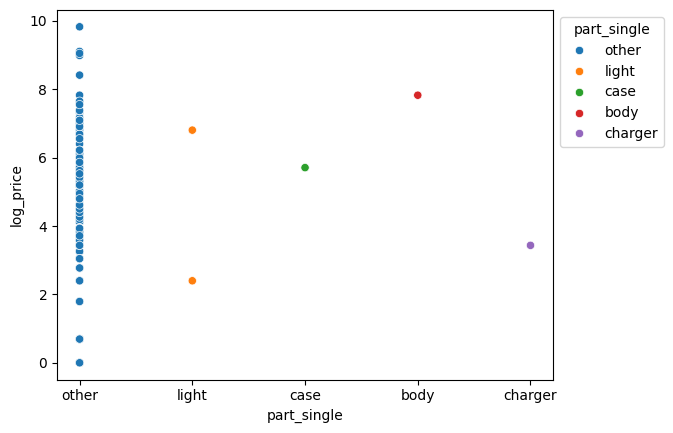

        log_price
count  174.000000
mean     4.609096
std      1.958442
min      0.000000
25%      3.616032
50%      4.615121
75%      5.707110
max      9.825580


In [10]:
df['log_price'] = np.log1p(df['price'])

ax = sns.scatterplot(data=df, x='part_single', y='log_price', hue='part_single')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# Since there's no 'age', we only check log_price stats
print(df[['log_price']].describe())

What we collected.
Owner-posted auto parts listings from Charlottesville Craigslist. For each tile we kept: title, price (parsed to numeric), link, inferred part_single (keyword from title: light, body, charger, filter, else other).

Cleaning.
Removed $/commas → numeric price; normalized titles to lower-case; mapped first matching keyword to part_single. Zero prices (e.g., “contact for price”) were left in but excluded for log transforms.

Distribution of prices (n = 171).

Median ≈ $100 (IQR $40 → $297.50).

Mean ≈ $450 with σ ≈ $1,146 because of a few very expensive items (max ≈ $9,000; min = $0).

Histogram shows a strong right skew—most items are inexpensive, with a long tail of high-ticket parts.

Relationships we see.

By part type: commodity items like chargers/filters are consistently low-priced; body and light parts show wider and higher spreads (but sample sizes per keyword are small).

Log-price compresses the long tail and makes category differences easier to see; divide-by-zero warnings occur if zero-priced rows aren’t filtered first.

Takeaways.

Typical auto-part purchases here are low to mid priced (median $100), while a small set of listings drives up the mean.

Simple keyword tagging suggests systematic price differences—commodity parts cheap; broader/structural parts vary more.

For a representative summary, median/IQR is more informative than the mean due to outliers.

Limitations / ethics.
Titles are short/inconsistent, so keyword categories are noisy; some prices are placeholders (0). Scraping was done politely (custom user-agent, limited pages) and used only public owner-posted data for coursework.

If extending: follow each listing link for richer fields (OEM/condition), expand the keyword list, and consider winsorizing the top 1% to stabilize summaries.